Aquí proporcionamos una breve descripción de cada función.

- **encounter ID**  Identificador único de un encuentro
- **patient number** Identificador único de un paciente
- **Race** valores de caucásico, asiático, afroamericano, hispano y otros
- **gender**  masculino, femenino y desconocido/no válido
- **age** Agrupada en intervalos de 10 años: 0, 10), 10, 20),…, 90, 100)
- **weight** Peso en libras
- **admission type** Identificador entero correspondiente a 9 valores distintos, por ejemplo, emergencia, urgente, electiva, recién nacido y no disponible
- **discharge disposition** Identificador entero correspondiente a 29 valores distintos, por ejemplo, descargada a domicilio, caducada y no disponible
- **admission source** Identificador entero correspondiente a 21 valores distintos, por ejemplo, referencia médica, sala de emergencias y traslado desde un hospital
- **time in hospital** Número entero de días entre el ingreso y el alta
- **payer code** Identificador entero correspondiente a 23 valores distintos, por ejemplo, Blue Cross/Blue Shield, Medicare y pago médico por cuenta propia
- **medical specialty** Identificador entero de una especialidad del médico de admisión, correspondiente a 84 valores distintos, por ejemplo, cardiología, medicina interna, medicina familiar/general y cirujano
- **number of lab procedures**  Número de pruebas de laboratorio realizadas durante el encuentro
- **number of procedure** Numérico Número de procedimientos (que no sean pruebas de laboratorio) realizados durante el encuentro
- **number of medications** Número de nombres genéricos distintos administrados durante el encuentro
- **number of outpatient visits** Número de visitas ambulatorias del paciente en el año anterior al encuentro
- **number of emergency visits** Número de visitas de emergencia del paciente en el año anterior al encuentro
- **number of inpatient visits** Número de visitas de pacientes hospitalizados del paciente en el año anterior al encuentro
- **diagnosis 1** El diagnóstico principal (codificado como los primeros tres dígitos de ICD9); 848 valores distintos
- **diagnosis 2** Diagnóstico secundario (codificado como los primeros tres dígitos de ICD9); 923 valores distintos
- **diagnosis 3** Diagnóstico secundario adicional (codificado como los primeros tres dígitos de ICD9); 954 valores distintos
- **number of diagnoses** Número de diagnósticos ingresados al sistema 0%
- **glucose serum test result** Indica el rango del resultado o si no se realizó la prueba. Valores: ">200", ">300", "normal" y "ninguno" si no se mide
- **A1c test result** Indica el rango del resultado o si no se realizó la prueba. Valores: “>8” si el resultado fue mayor al 8%, “>7” si el resultado fue mayor al 7% pero menor al 8%, “normal” si el resultado fue menor al 7% y “ninguno” si no medido
- **change of medications** Indica si hubo cambio de medicamentos para diabéticos (ya sea de dosis o de nombre genérico). Valores: “cambio” y “sin cambio”
Medicamentos para la diabetes Indica si se prescribió algún medicamento para la diabetes. Valores: “sí” y “no”
24 tipos diferentes de medicamentos.
- **readmitted** Días hasta la readmisión de pacientes hospitalizados. Valores: “❤0” si el paciente reingresó en menos de 30 días, “>30” si el paciente reingresó en más de 30 días y “No” si no hay registro de reingreso

In [77]:
# Importar  librerias  necesarias para el analisis de readmision hospitalaria de pacientes en condición clínica de diabetes
from src.utils import plot_count , check_label, barplot_per_classes, kdeplot_per_classes , boxplot_per_classes
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly 
import plotly.express as px
#import scipy 
import warnings
warnings.filterwarnings("ignore")


In [78]:
# cargue de  data set desde  raiz del proyecto formato csv
data = pd.read_csv('./data/diabetic_data.csv', na_values='?', low_memory=False)
IDs_mapping= pd.read_csv('./data/IDs_mapping.csv', na_values='?', low_memory=False)

data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [79]:

# Encontrar la posición de la fila que contiene registros NaN
posicion = np.where(IDs_mapping.isna().all(axis=1))
# se divide el dataset de mapping en 3, con el objetivo de identificar los merge`s` completos 

admission_type_id = IDs_mapping.iloc[:posicion[0][0], : ]
admission_type_id.columns = ['admission_type_id' , 'admission_type']
admission_type_id['admission_type_id'] = admission_type_id['admission_type_id'].astype(int)

 
discharge_disposition_id = IDs_mapping.iloc[posicion[0][0]+2:posicion[0][1], : ]
discharge_disposition_id.columns = ['discharge_disposition_id',	'discharge_disposition']
discharge_disposition_id['discharge_disposition_id']  = discharge_disposition_id['discharge_disposition_id'].astype(int)

admission_source_id = IDs_mapping.iloc[posicion[0][1]+2:, : ]
admission_source_id.columns = ['admission_source_id','admission_source']
admission_source_id['admission_source_id'] = admission_source_id['admission_source_id'].astype(int)

In [80]:
'''
Realizar desnormalizacion de  la data para poder opservar analisis de categorias  sobre las variables:
* admission_type 
* discharge_disposition
* admission_source
'''

df = pd.merge(data, admission_type_id, on='admission_type_id')
df = pd.merge(df, discharge_disposition_id, on='discharge_disposition_id')
df = pd.merge(df, admission_source_id, on='admission_source_id')

cols = df.columns.difference(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])

df= df[cols]



In [81]:
# chequeo base  para  de cantidad de registros  que se tiene en el dataset
print(f'Cantidad de registros : {df.shape[0]} \nCantidad de columnas :{df.shape[1]}' )
print(f'Datos duplicados? : {df.duplicated().any()}')

Cantidad de registros : 101766 
Cantidad de columnas :50
Datos duplicados? : False


Incluso no hay duplicados, los registros representan encuentros individuales, por lo que puede haber más encuentros para un solo paciente. Comprobemos el número de encuentros y el número de pacientes:

In [82]:
print (f'Cantidad de encuentros con el paciente : {len(df.encounter_id.unique())} \nCantidad de pacientes atendidos en el counter: {len(df.patient_nbr.unique())}')

Cantidad de encuentros con el paciente : 101766 
Cantidad de pacientes atendidos en el counter: 71518


In [83]:
### descriptivas fundamentales por cada una de las  variables numericas
df.describe()

,encounter_id,num_lab_procedures,num_medications,num_procedures,number_diagnoses,number_emergency,number_inpatient,number_outpatient,patient_nbr,time_in_hospital
count,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,1.017660e+05,101766.000000
mean,1.652016e+08,43.095641,16.021844,1.339730,7.422607,0.197836,0.635566,0.369357,5.433040e+07,4.395987
std,1.026403e+08,19.674362,8.127566,1.705807,1.933600,0.930472,1.262863,1.267265,3.869636e+07,2.985108
min,1.252200e+04,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.350000e+02,1.000000
25%,8.496119e+07,31.000000,10.000000,0.000000,6.000000,0.000000,0.000000,0.000000,2.341322e+07,2.000000
50%,1.523890e+08,44.000000,15.000000,1.000000,8.000000,0.000000,0.000000,0.000000,4.550514e+07,4.000000
75%,2.302709e+08,57.000000,20.000000,2.000000,9.000000,0.000000,1.000000,0.000000,8.754595e+07,6.000000
max,4.438672e+08,132.000000,81.000000,6.000000,16.000000,76.000000,21.000000,42.000000,1.895026e+08,14.000000


In [84]:
## frecuencia  y cantidad de valores unicos en cada  variable categorica 
df.describe(exclude=[np.number])

,A1Cresult,acarbose,acetohexamide,admission_source,admission_type,age,change,chlorpropamide,citoglipton,diabetesMed,...,payer_code,pioglitazone,race,readmitted,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone,weight
count,101766,101766,101766,94985,96475,101766,101766,101766,101766,101766,...,61510,101766,99493,101766,101766,101766,101766,101766,101766,3197
unique,4,4,2,16,7,10,2,4,1,2,...,17,4,5,3,4,4,3,2,2,9
top,None,No,No,Emergency Room,Emergency,[70-80),No,No,No,Yes,...,MC,No,Caucasian,NO,No,No,No,No,No,[75-100)
freq,84748,101458,101765,57494,53990,26068,54755,101680,101766,78363,...,32439,94438,76099,54864,100227,95401,101727,101743,101763,1336


Desde este punto de vista, podemos ver que algunos de los atributos parecen numéricos, pero también contienen cadenas (como None). Tendremos que comprobar eso mejor y analizarlos individualmente, porque esos atributos pueden representar por ejemplo algunos códigos o simplemente los resultados de algunas medidas.

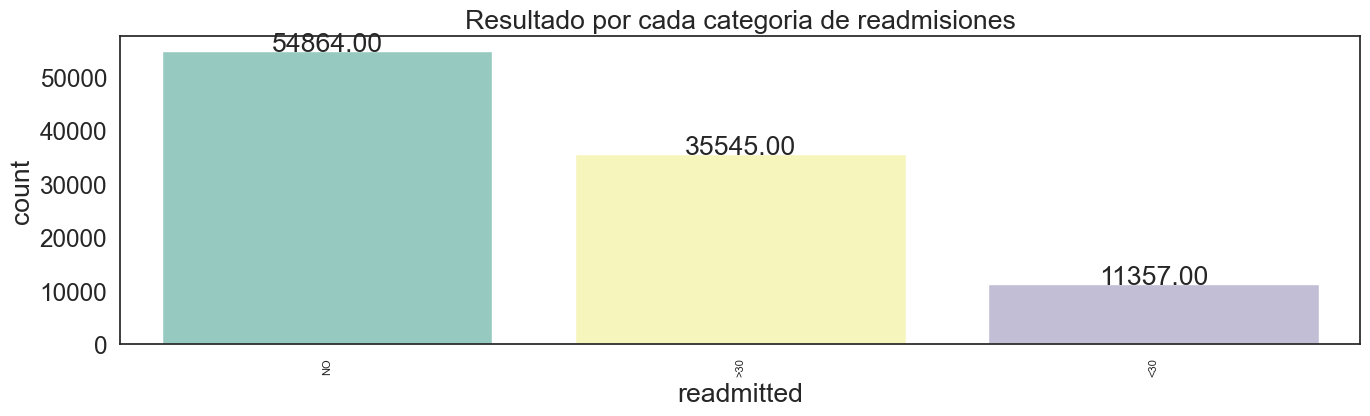

In [85]:
name = df.readmitted.value_counts().index
num  = df.readmitted.value_counts().values

fig = px.pie(data_frame=df,names=name,values=num
             ,title='Grafico de  pie sobre  los resultados de readmisión',width=800,height=600)
fig.update_traces(textposition='inside',textinfo='label+percent')
fig.show()

plot_count('readmitted', 'readmisiones', df, size=4)

In [86]:
# se crea columna  con el nombre label , la cual va a almacenar la recategorizacion del campo readmission ( la cual fue dicotomizada)
# ya qeu es de interes saber si se presenta o no una readmision del paciente diabetico
df['label'] = df.readmitted.apply(check_label) 
df.label.value_counts()

No    54864
Si    46902
Name: label, dtype: int64

In [87]:
t = PrettyTable(['Nombre columna', 'cant. valores perdidos', '% valores perdidos'])
for column in df.columns:
    missing_count = len(df[column][df[column].isna()])
    missing_percentage = round(missing_count / len(df) * 100, 2)
    if missing_count > 0:
        #print(f'{column}: {missing_count} ({missing_percentage}%)')
        t.add_row([column,missing_count,f'{missing_percentage}%'])
print(t)    

+-----------------------+------------------------+--------------------+
|     Nombre columna    | cant. valores perdidos | % valores perdidos |
+-----------------------+------------------------+--------------------+
|    admission_source   |          6781          |       6.66%        |
|     admission_type    |          5291          |        5.2%        |
|         diag_1        |           21           |       0.02%        |
|         diag_2        |          358           |       0.35%        |
|         diag_3        |          1423          |        1.4%        |
| discharge_disposition |          3691          |       3.63%        |
|   medical_specialty   |         49949          |       49.08%       |
|       payer_code      |         40256          |       39.56%       |
|          race         |          2273          |       2.23%        |
|         weight        |         98569          |       96.86%       |
+-----------------------+------------------------+--------------

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64


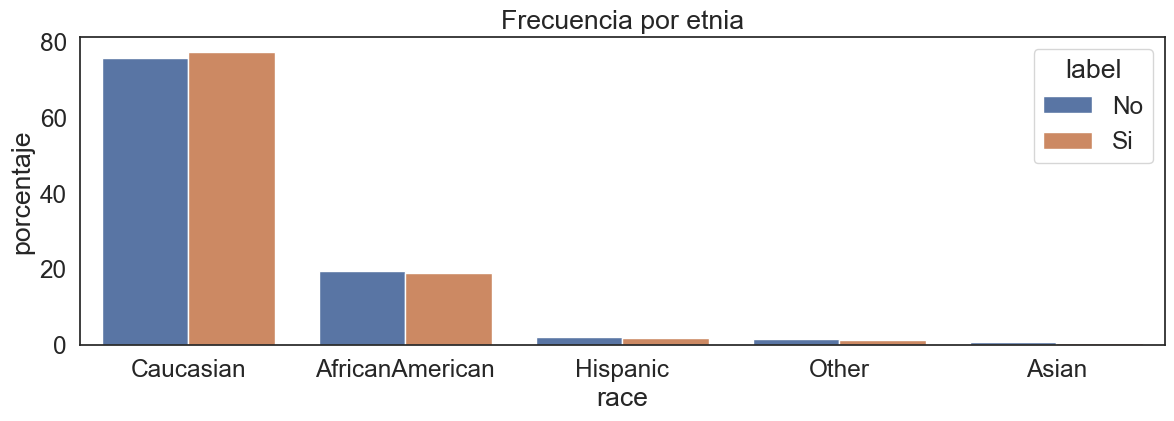

In [88]:
print(df.race.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'race', 'label', 'Frecuencia por etnia')


Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64


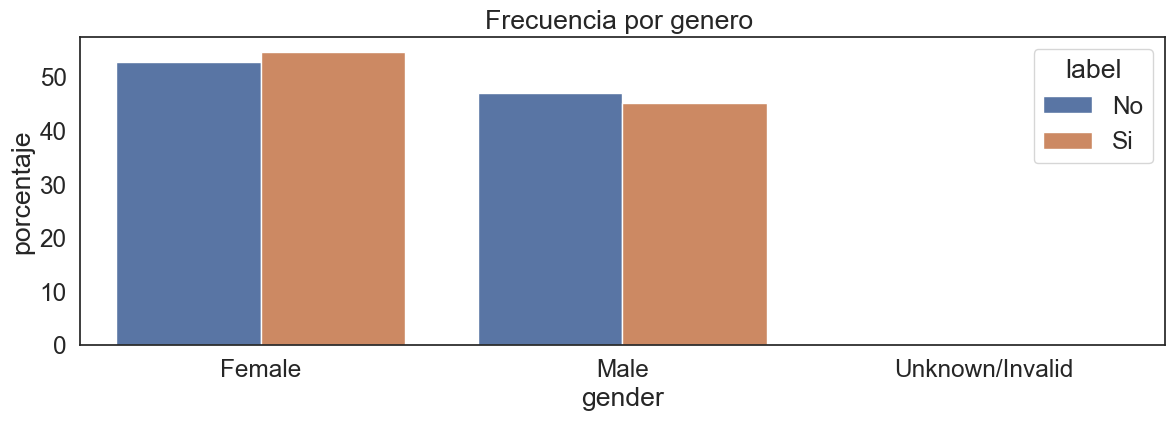

In [89]:
print(df.gender.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'gender', 'label', 'Frecuencia por genero ')

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64


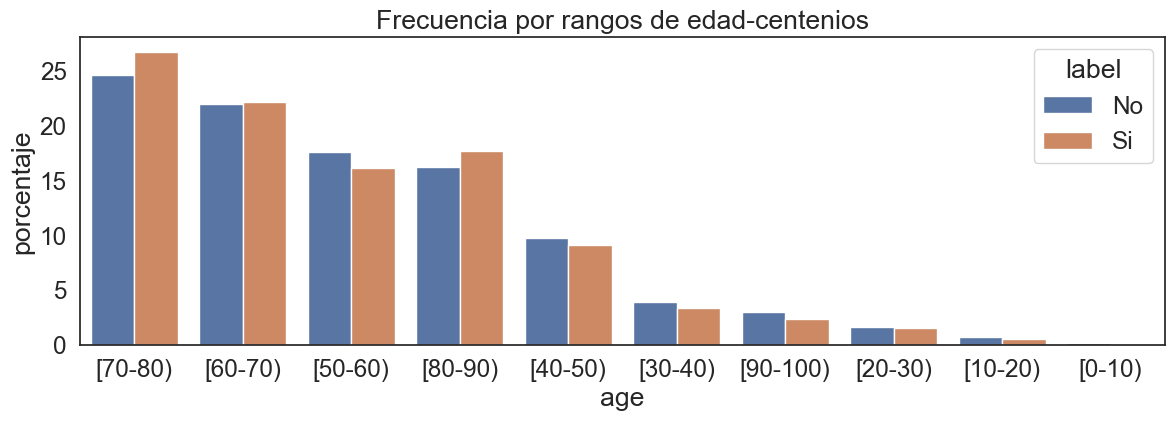

In [90]:
print(df.age.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'age', 'label', 'Frecuencia por rangos de edad-centenios')

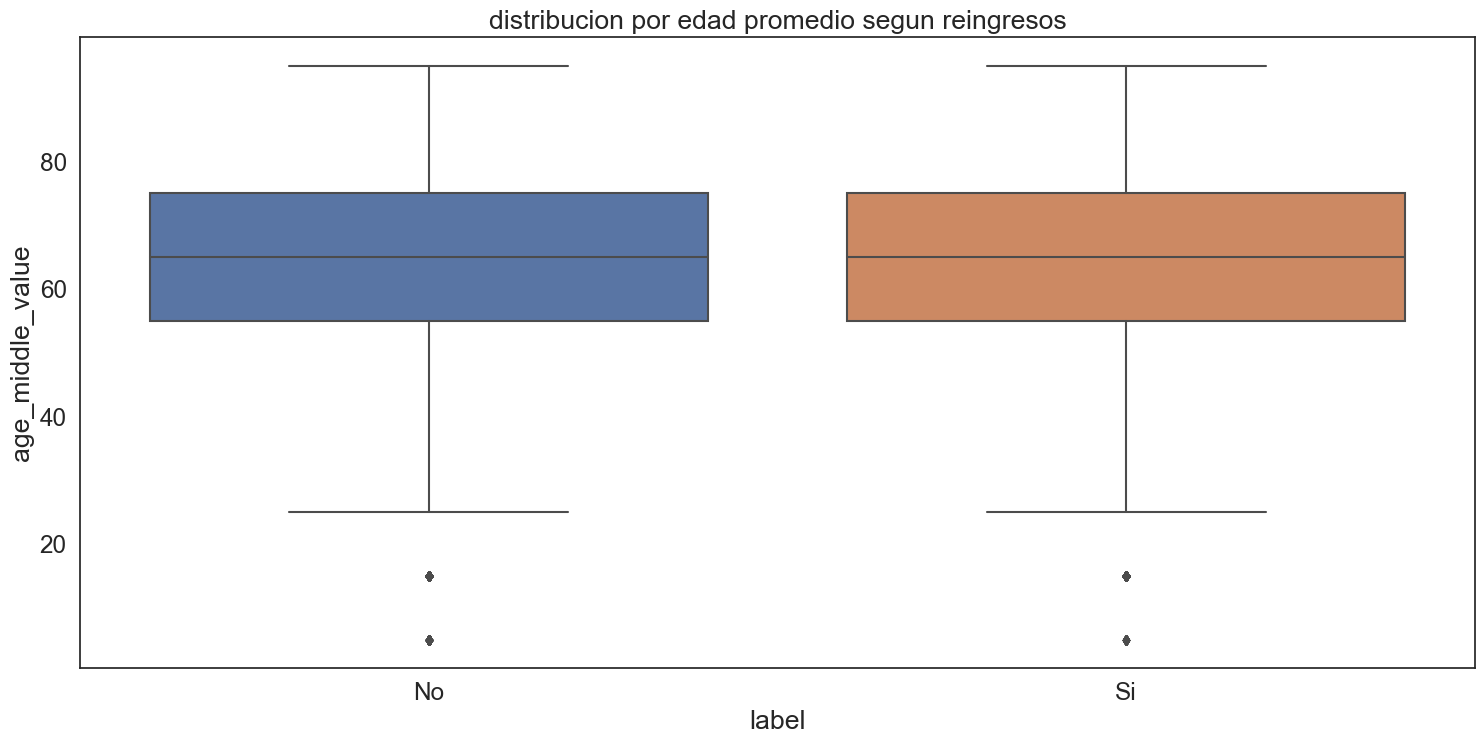

In [91]:
## Se toma la decision de  realizar una calculo sobre los intervalos de edad, con el objetivo de obtener la edad promedio dentro de cada intervalo.
def convert_age(age):
    """
    Convertir el campo edad  de intervalos en valores medios 
    
    :param age: intervalos de  la edad registrados en el dataframe.
    :return: valores medios de edad sobre cada intervalo de las edades ( decenios).
    """
    age = age[1:-1]
    lower_boundary = int(age.split('-')[0])
    upper_boundary = int(age.split('-')[1])
    return (upper_boundary + lower_boundary) / 2


df['age_middle_value'] = df['age'].apply(lambda x: convert_age(x))
boxplot_per_classes(df, 'age_middle_value', 'label' , 'distribucion por edad promedio segun reingresos')

Emergency        53990
Elective         18869
Urgent           18480
Not Available     4785
Not Mapped         320
Trauma Center       21
Newborn             10
Name: admission_type, dtype: int64


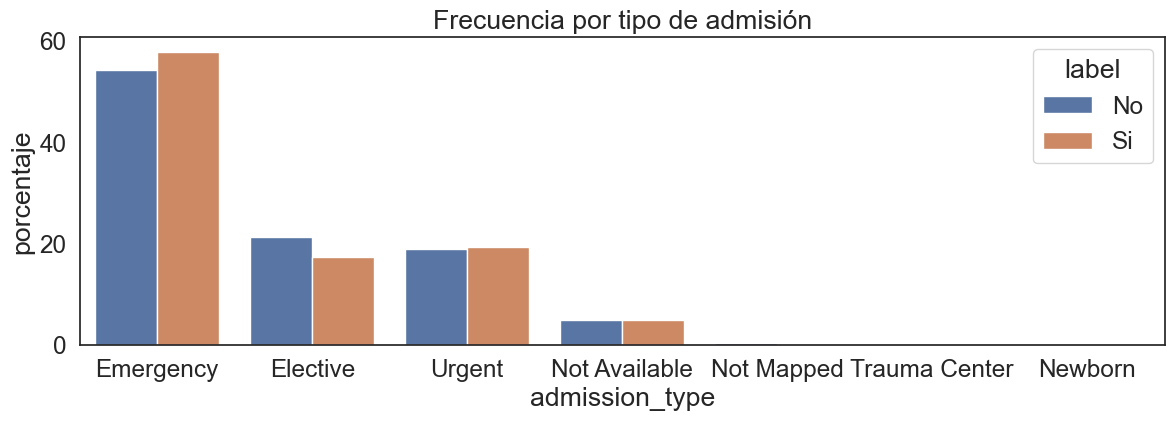

In [92]:
print(df.admission_type.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'admission_type', 'label', 'Frecuencia por tipo de admisión')

Discharged to home                                                                                           60234
Discharged/transferred to SNF                                                                                13954
Discharged/transferred to home with home health service                                                      12902
Discharged/transferred to another short term hospital                                                         2128
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1993
Expired                                                                                                       1642
Discharged/transferred to another type of inpatient care institution                                          1184
Not Mapped                                                                                                     989
Discharged/transferred to ICF                                                   

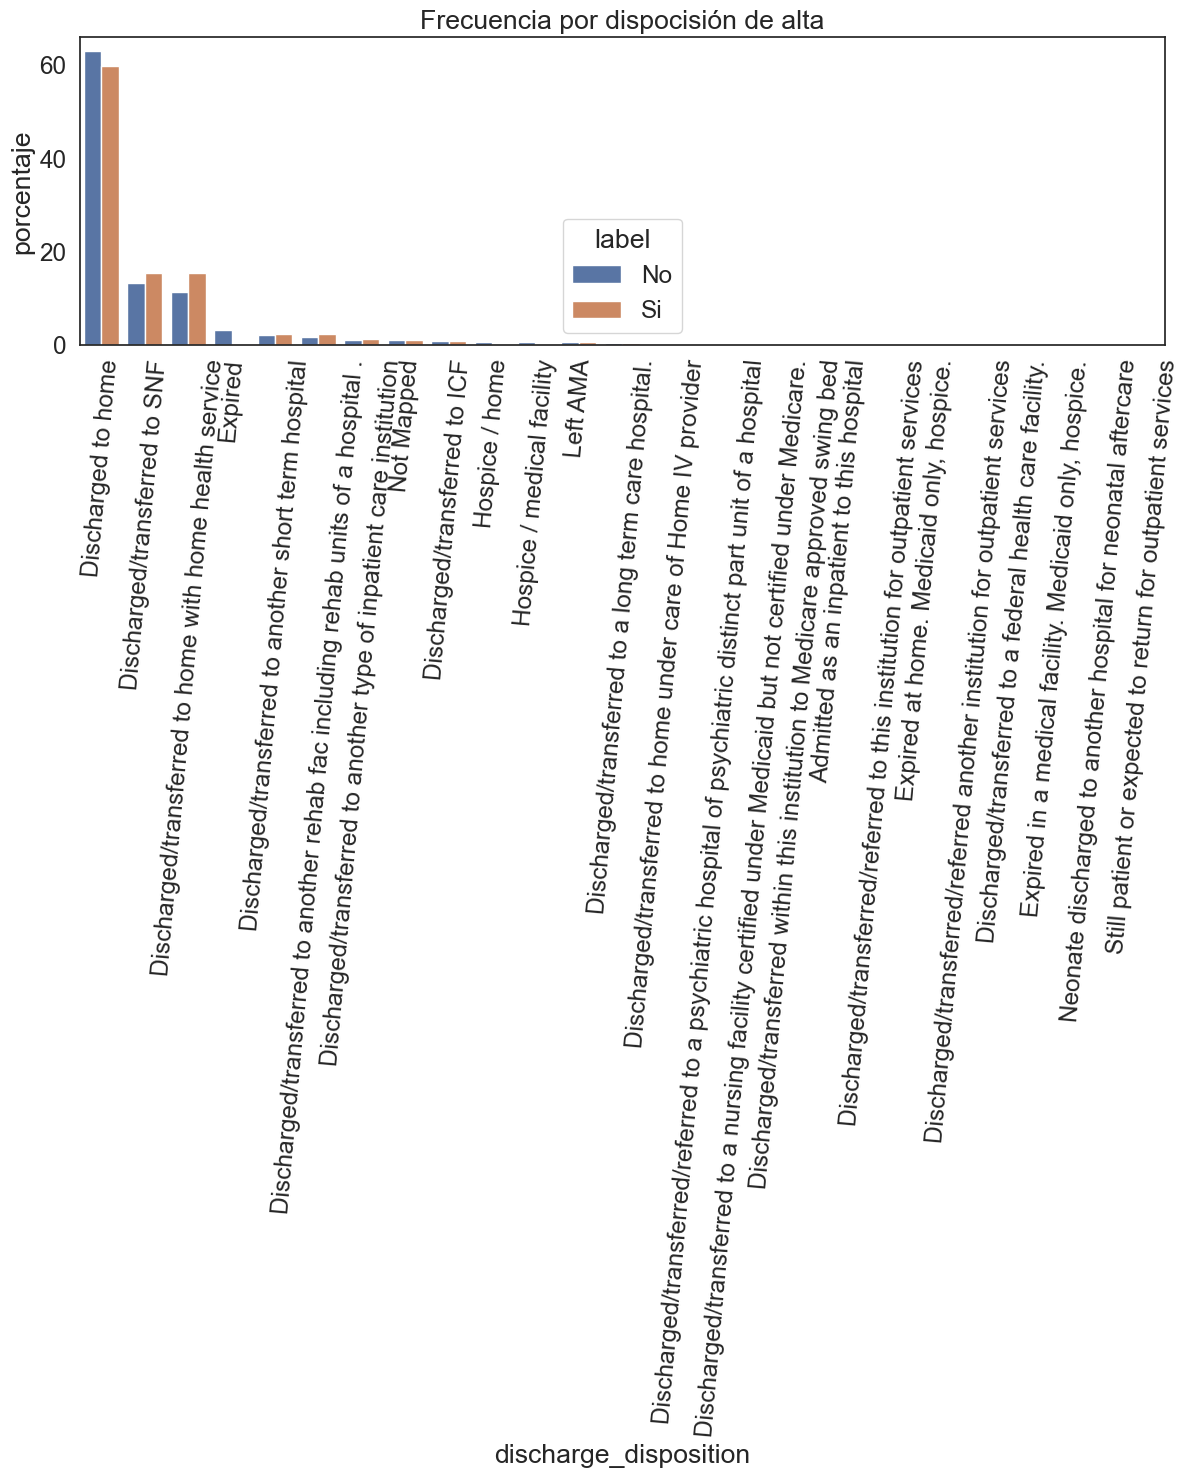

In [93]:

print(df.discharge_disposition.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'discharge_disposition', 'label', 'Frecuencia por dispocisión de alta', ticks_rotation=85)

 Emergency Room                                               57494
 Physician Referral                                           29565
Transfer from a hospital                                       3187
 Transfer from another health care facility                    2264
Clinic Referral                                                1104
 Transfer from a Skilled Nursing Facility (SNF)                 855
HMO Referral                                                    187
 Not Mapped                                                     161
 Not Available                                                  125
 Court/Law Enforcement                                           16
 Transfer from hospital inpt/same fac reslt in a sep claim       12
 Transfer from critial access hospital                            8
 Extramural Birth                                                 2
Normal Delivery                                                   2
 Transfer from Ambulatory Surgery Center        

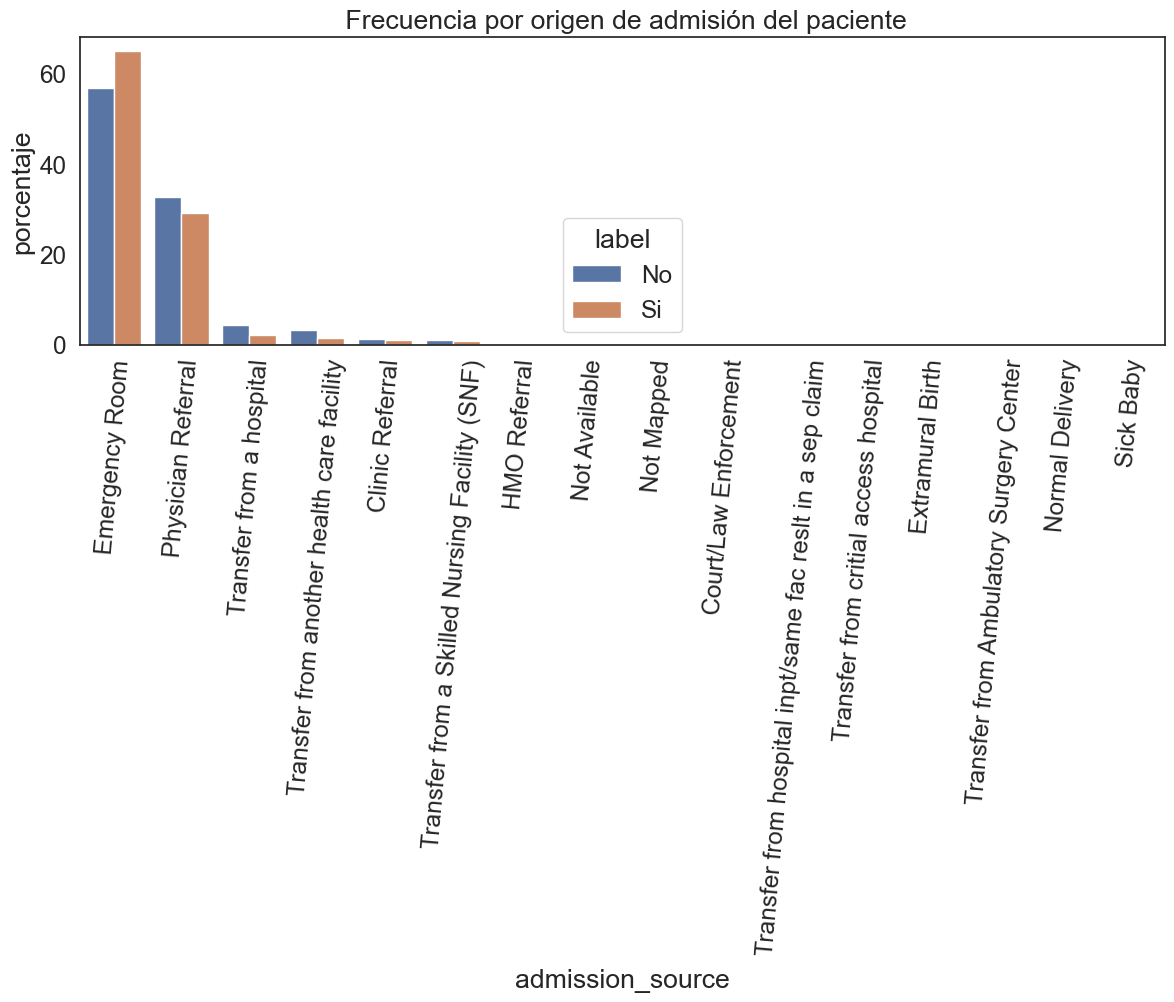

In [94]:
print(df.admission_source.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))

barplot_per_classes(df, 'admission_source', 'label', ' Frecuencia por origen de admisión del paciente', ticks_rotation=85)

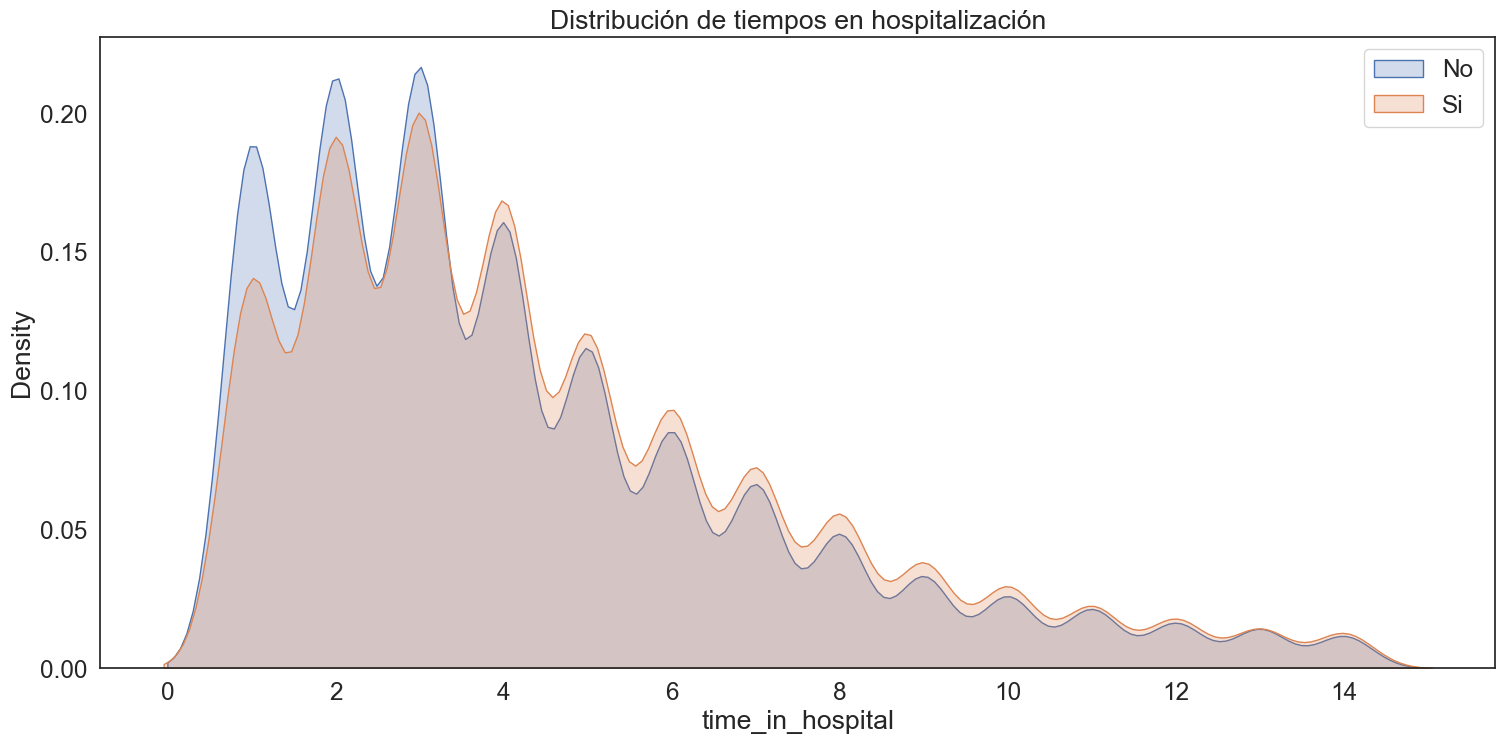

In [95]:
#  grafica de  la distribucion de  tiempos de hospitalizacion por cada categoria de readmision 
kdeplot_per_classes(df, 'time_in_hospital', 'label', 'Distribución de tiempos en hospitalización')


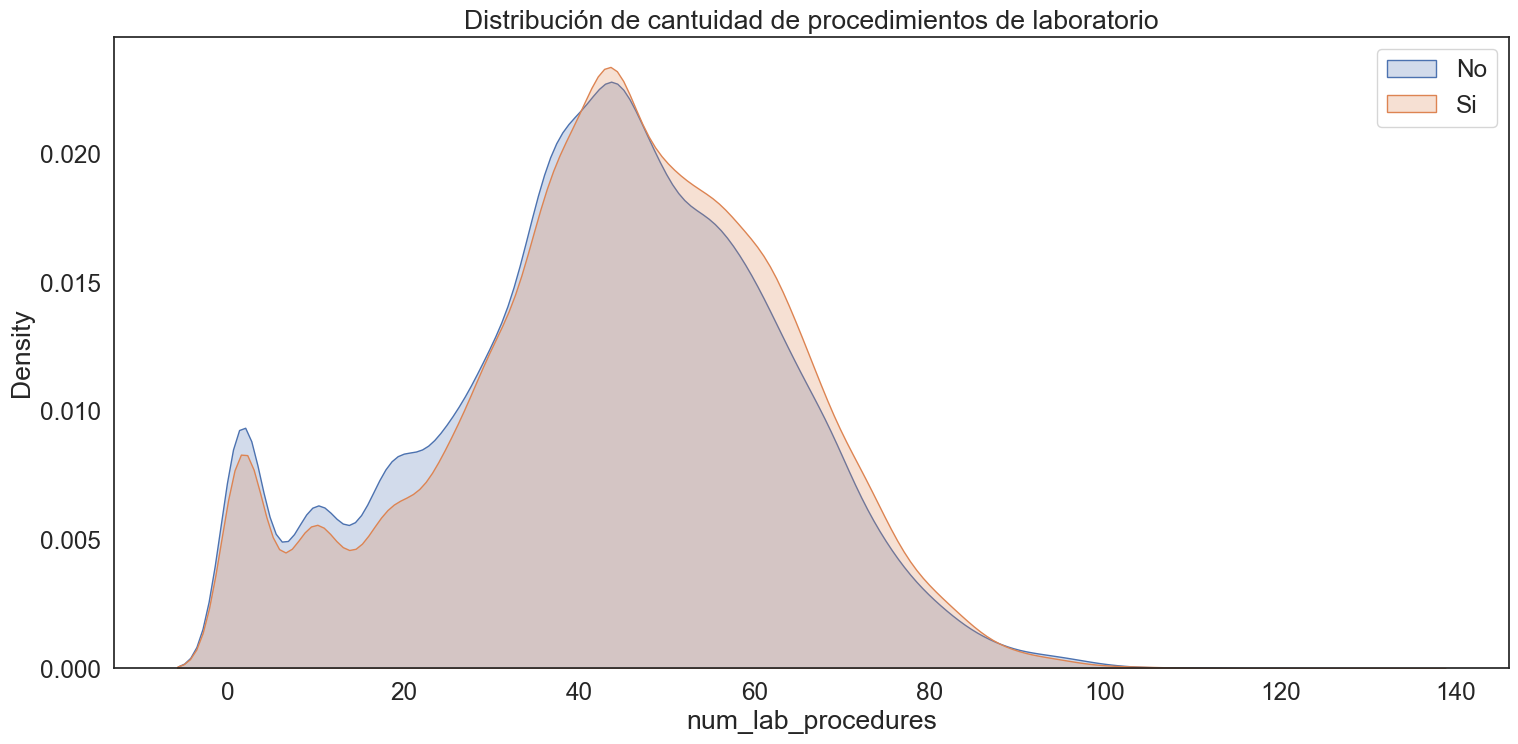

In [96]:
#  grafica de  la distribucion de  cantidad de procedimientos de lab por cada categoria de readmision 
kdeplot_per_classes(df, 'num_lab_procedures', 'label', 'Distribución de cantuidad de procedimientos de laboratorio')

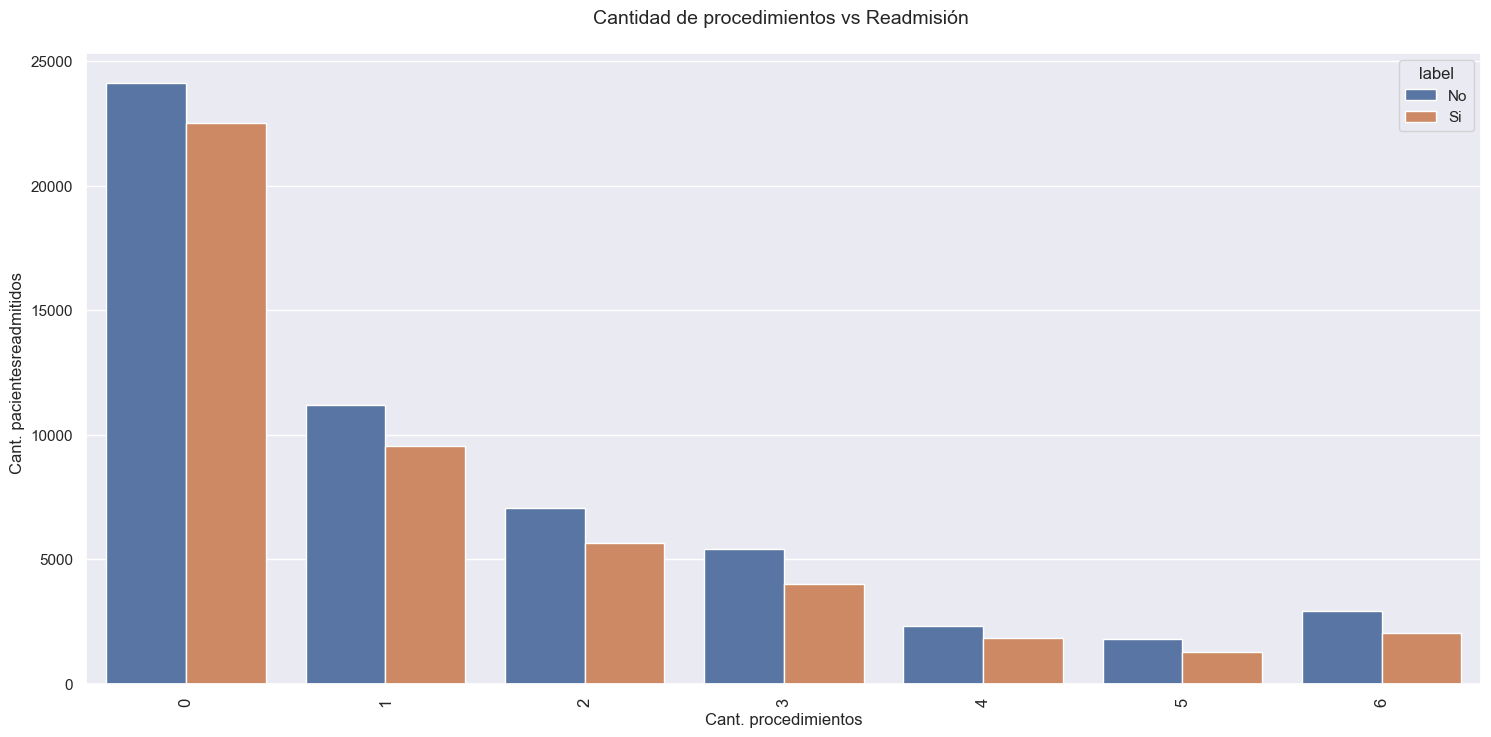

In [97]:
# grafica  de barras para la cantida de procedimientos realizados con referencia  a las categtorias de la readmision
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='num_procedures',  hue= 'label',  data= df)
plt.xlabel('Cant. procedimientos', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Cant. pacientesreadmitidos  ', size = 12)
plt.title('Cantidad de procedimientos vs Readmisión \n', size = 14)
plt.show()

Text(0.5, 1.0, 'Top 20 codigos de primeros diagnosticos en Readmision = No \n')

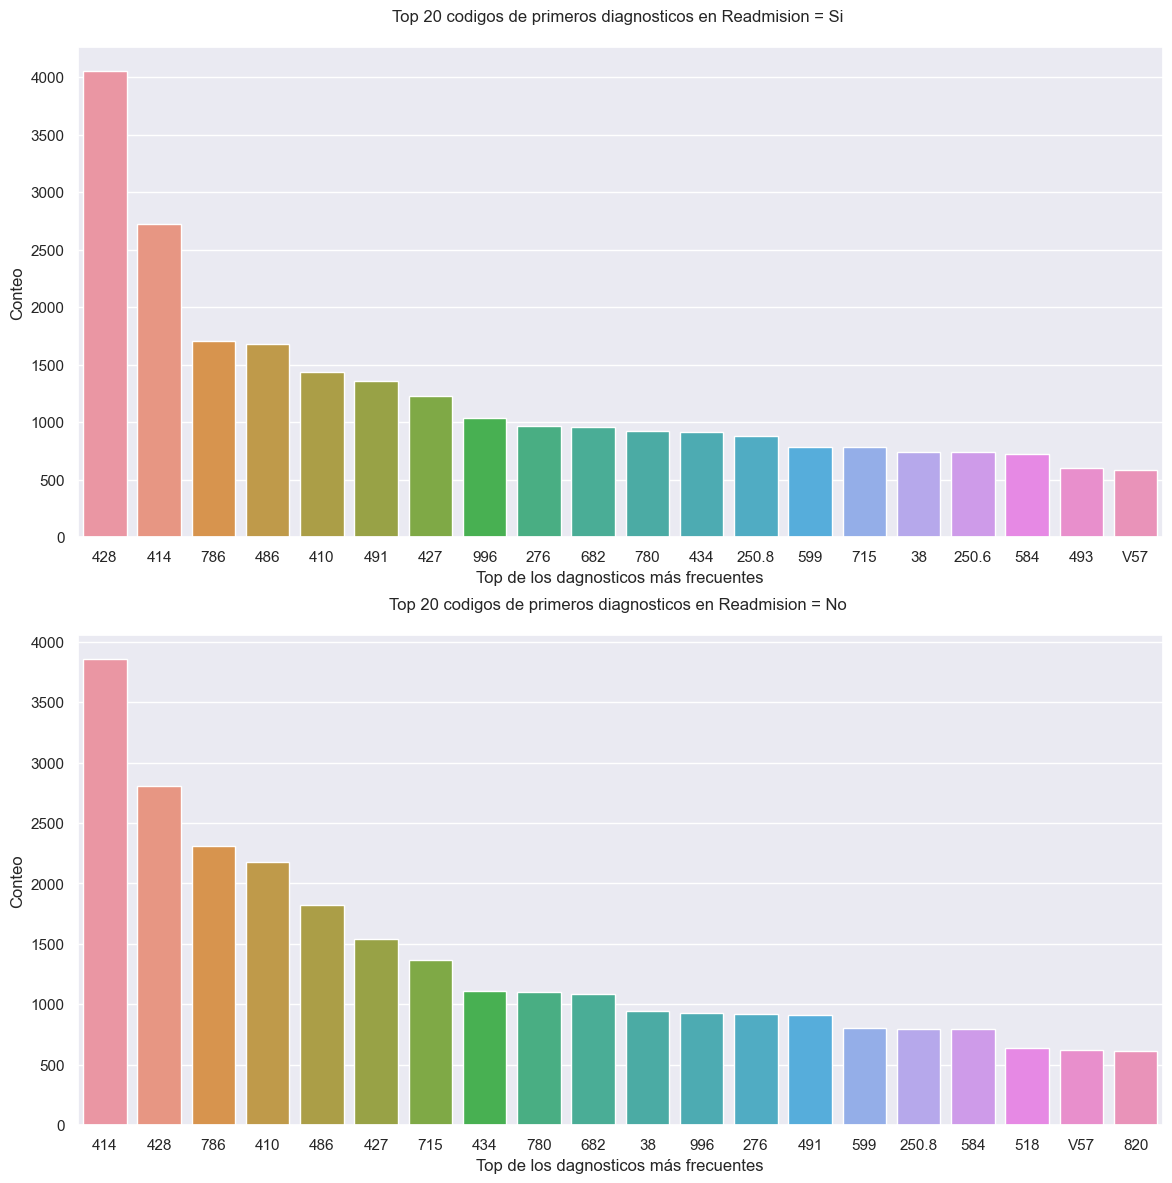

In [98]:
# graficas del top 20 de los codigos de diagnostico mas  concurridos  segun la categoria de readmision del paciente
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

sns.barplot(x=df[df['label'] == 'Si']['diag_1'].value_counts().index[:20],
                 y=df[df['label'] == 'Si']['diag_1'].value_counts()[:20] , ax = ax[0])

ax[0].set_xlabel('Top de los dagnosticos más frecuentes', size = 12)
ax[0].set_ylabel('Conteo', size = 12)
ax[0].set_title('Top 20 codigos de primeros diagnosticos en Readmision = Si \n', size = 12)


sns.barplot(x=df[df['label'] == 'No']['diag_1'].value_counts().index[:20],
                 y=df[df['label'] == 'No']['diag_1'].value_counts()[:20] , ax = ax[1])

ax[1].set_xlabel('Top de los dagnosticos más frecuentes', size = 12)
ax[1].set_ylabel('Conteo', size = 12)
ax[1].set_title('Top 20 codigos de primeros diagnosticos en Readmision = No \n', size = 12)


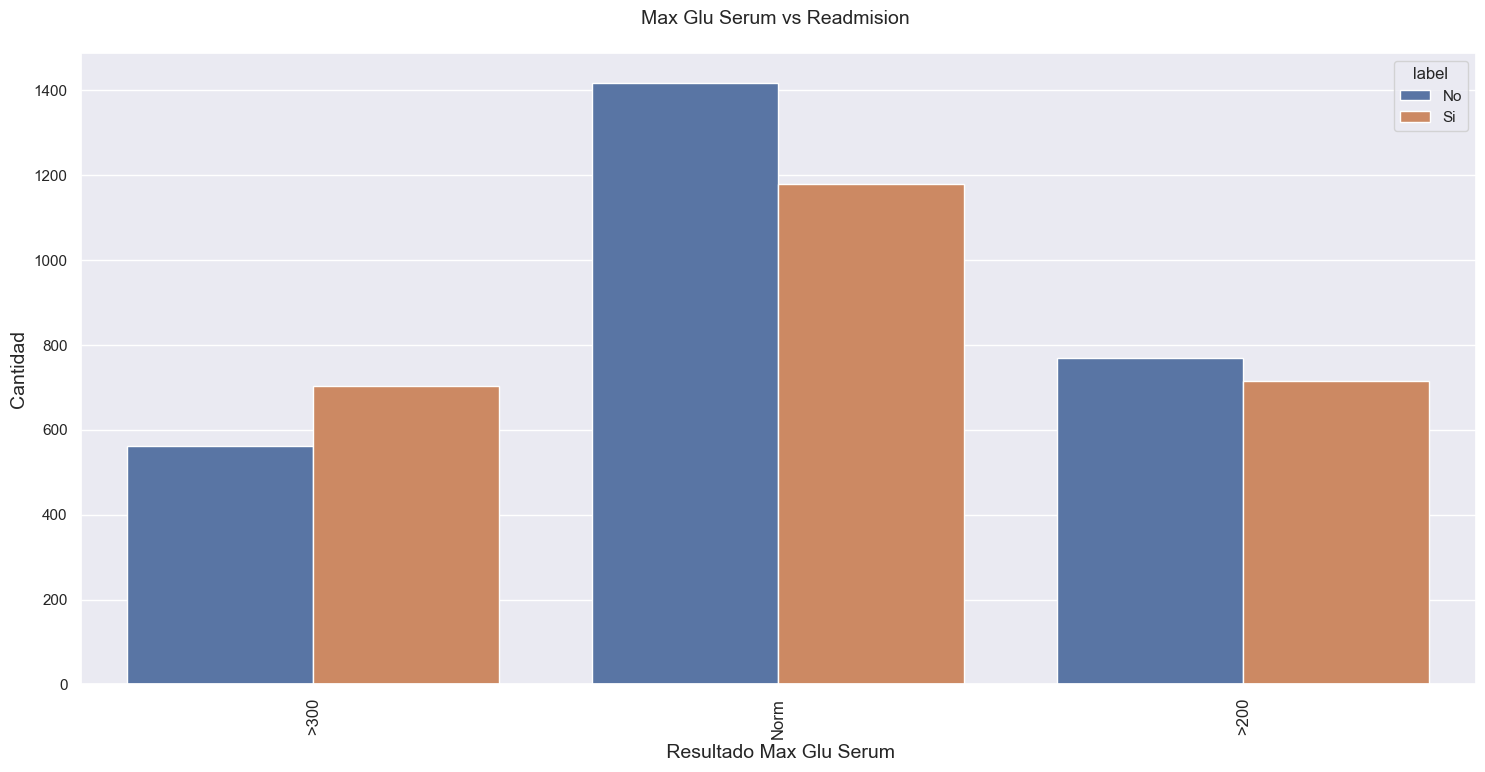

In [99]:
# niveles del resultado de la prueba diagnsotica Max Glu Serum  con referencia  al estado de readmision del paciente
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='max_glu_serum',  hue= 'label', data= df[df['max_glu_serum']!='None'])
plt.xlabel(' Resultado Max Glu Serum', size = 14)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Cantidad', size = 14)
plt.title('Max Glu Serum vs Readmision \n', size = 14)
plt.show()

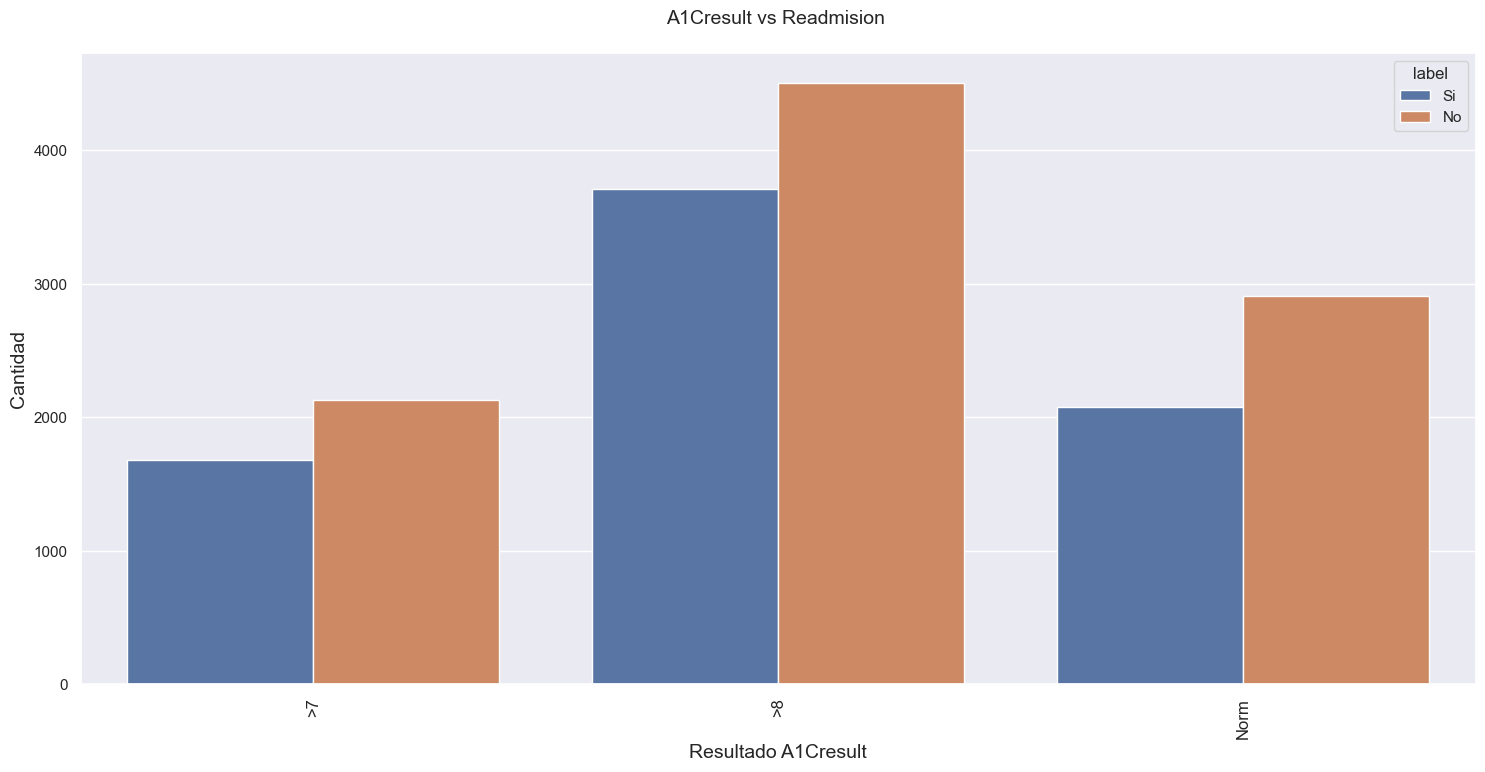

In [100]:
# niveles del resultado de la prueba diagnsotica A1Cresult con referencia  al estado de readmision del paciente

sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='A1Cresult', hue = 'label', data=df[df['A1Cresult']!='None'])
plt.xlabel('Resultado A1Cresult', size = 14)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Cantidad', size = 14)
plt.title('A1Cresult vs Readmision \n', size = 14)
plt.show()

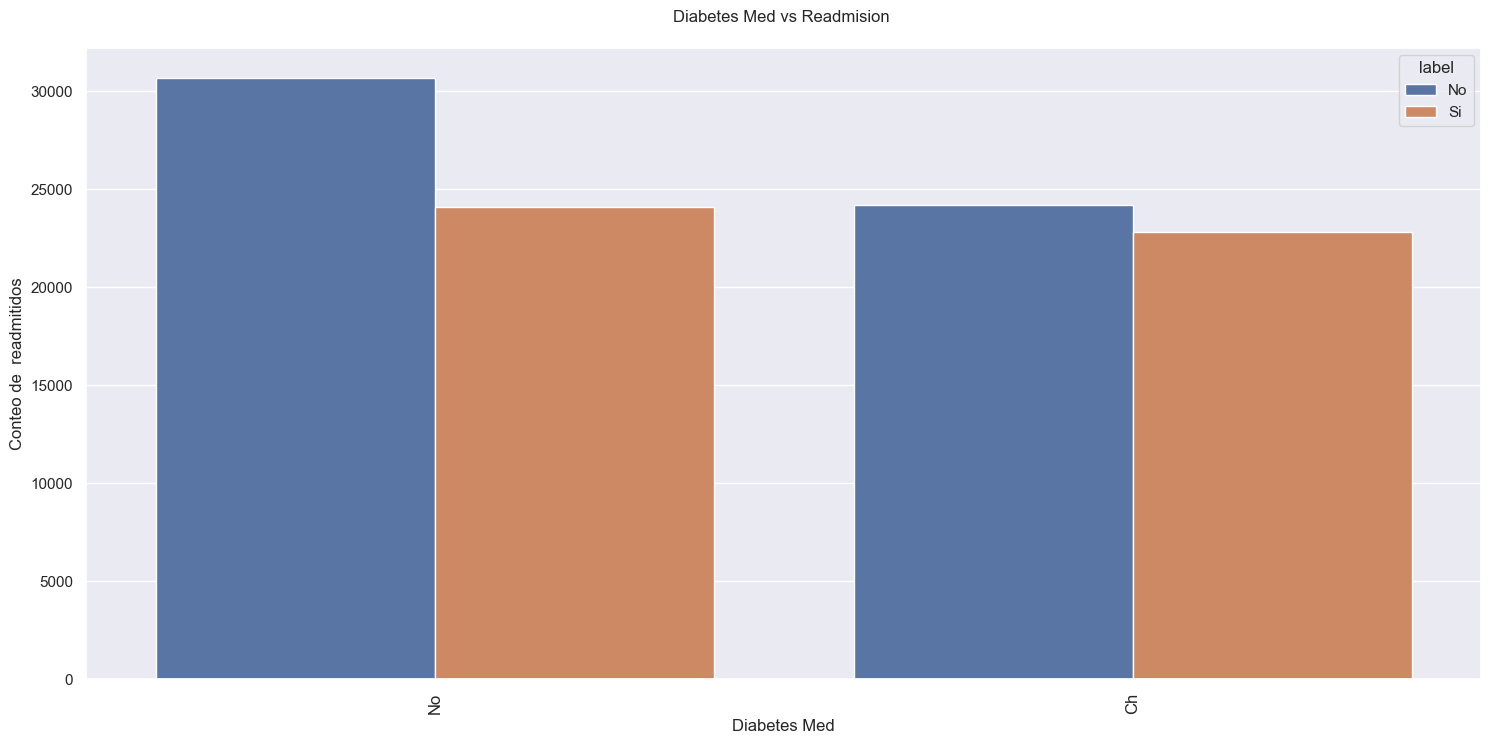

In [101]:
ax = sns.countplot(x='change',  hue= 'label',  data= df)
plt.xlabel('Diabetes Med', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Conteo de  readmitidos', size = 12)
plt.title('Diabetes Med vs Readmision \n', size = 12)
plt.show()

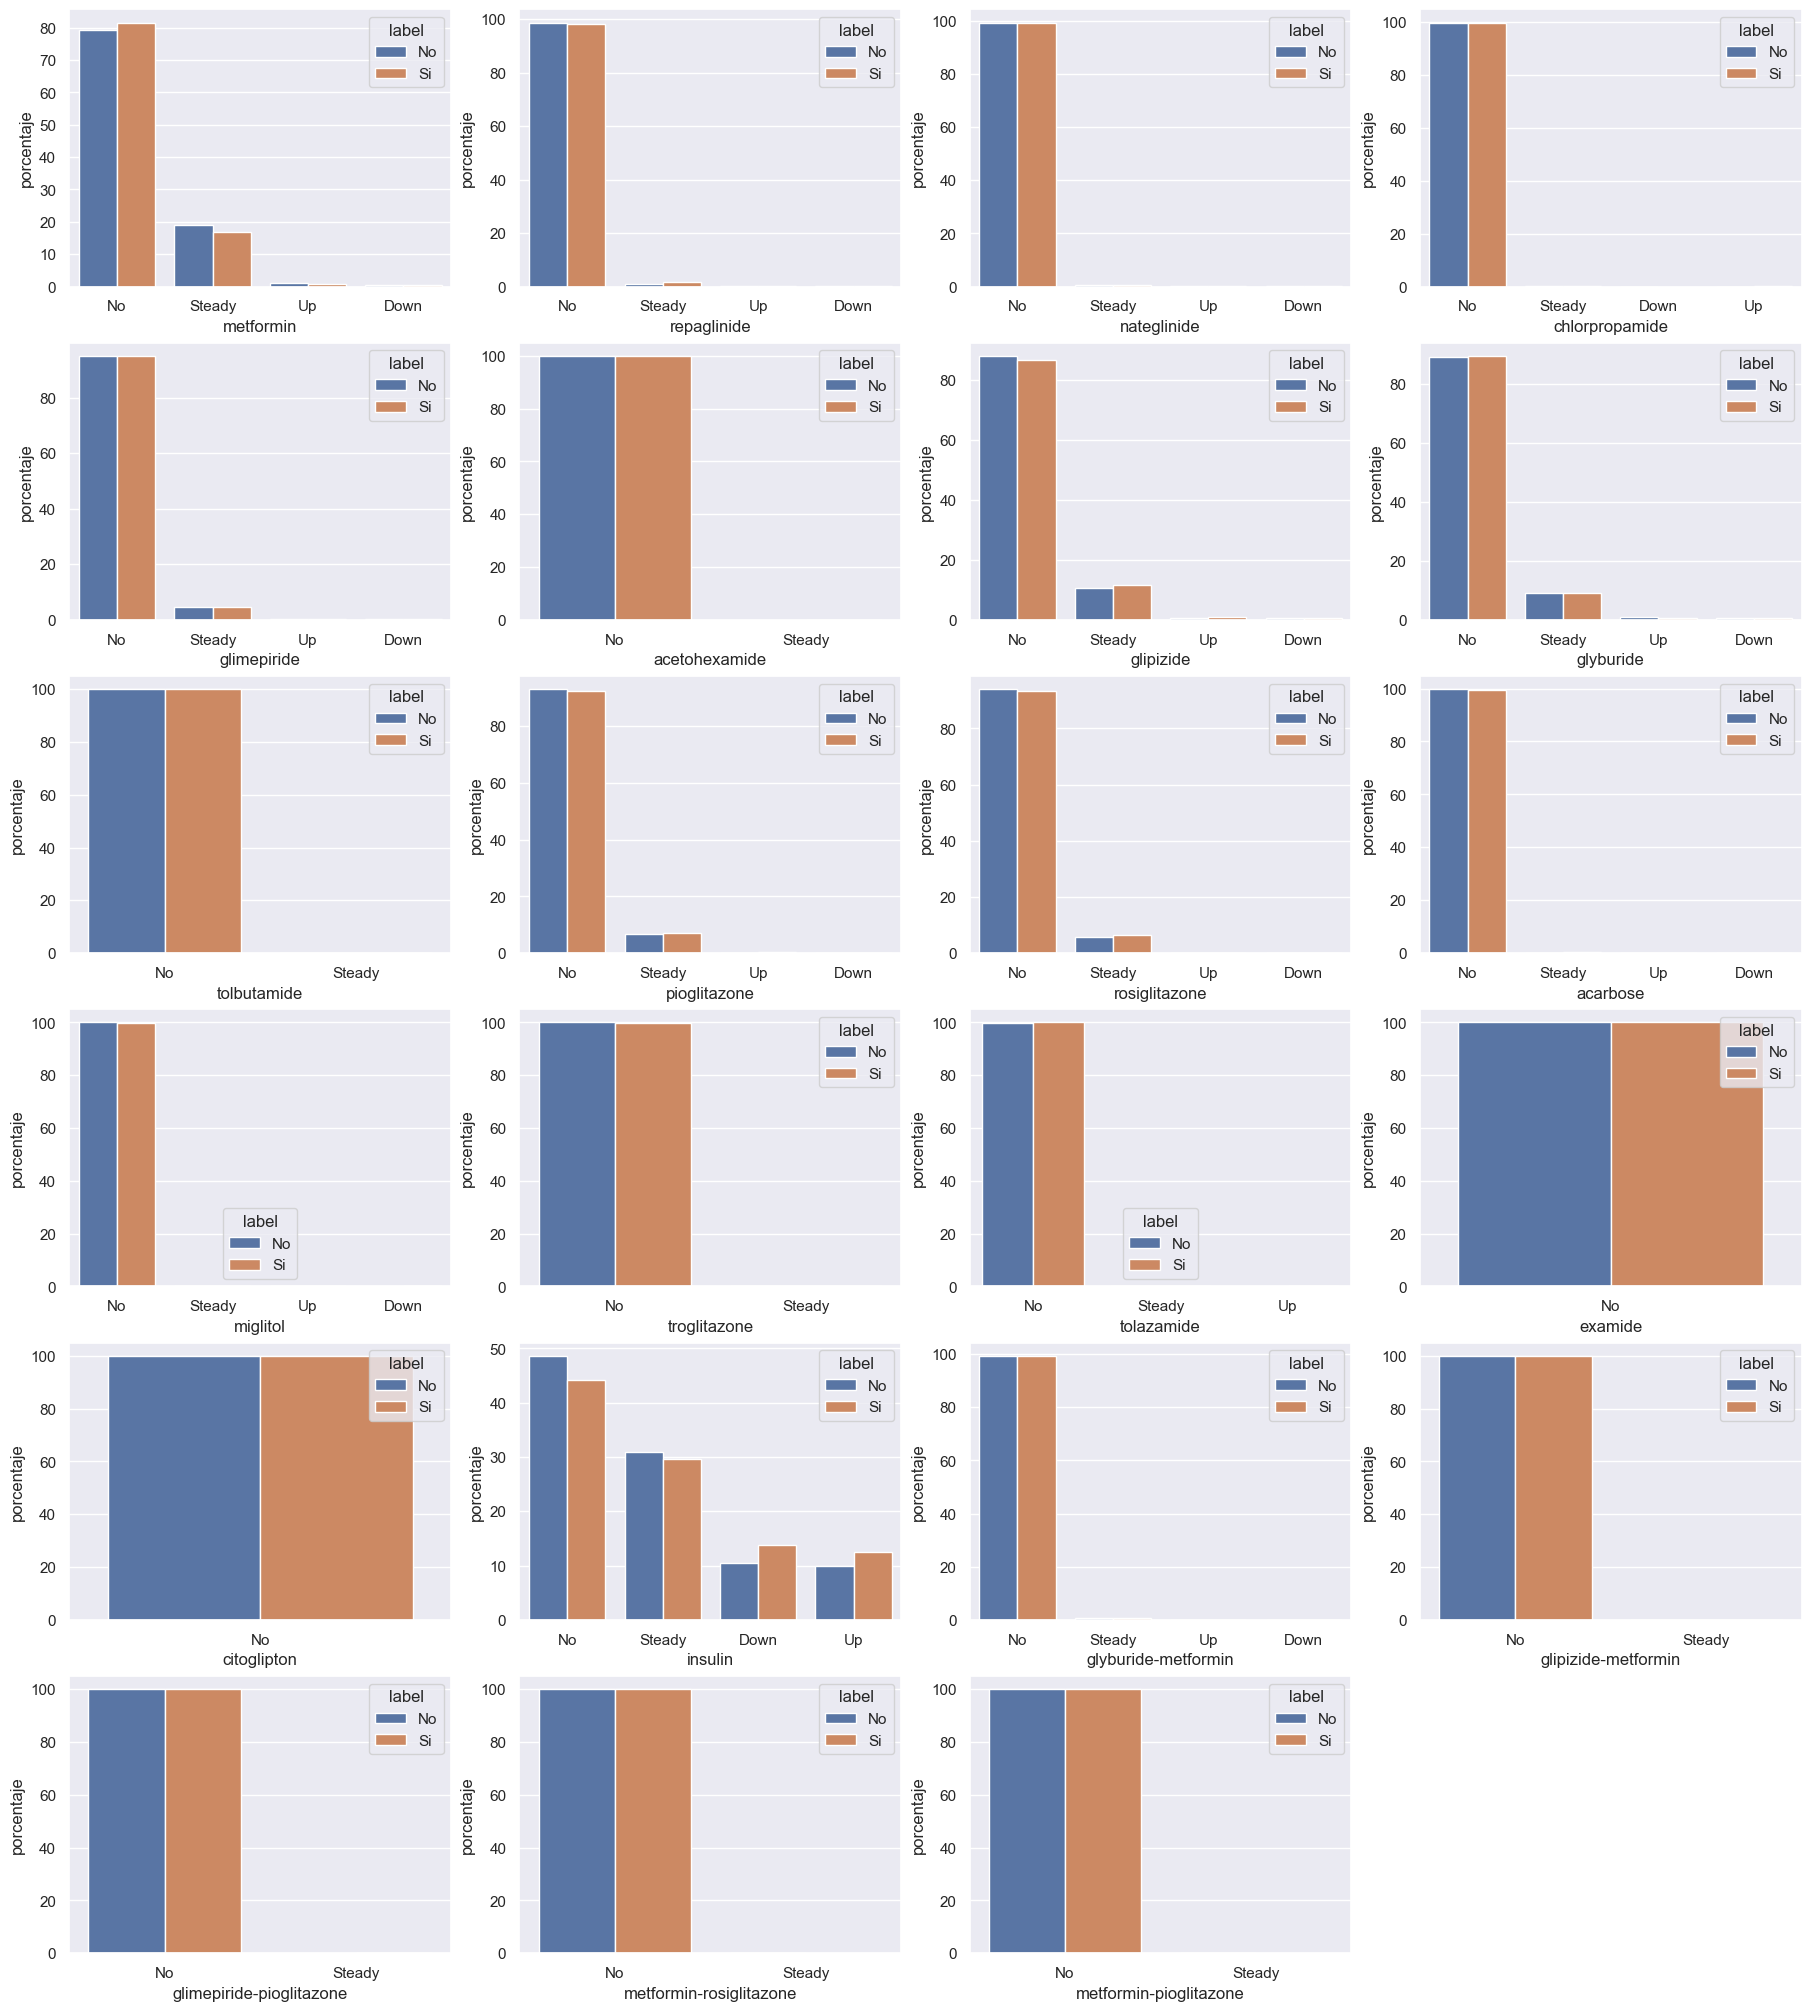

In [102]:
# analisis bivariado de  sobre la caracteristica de readmision del paciente con referencia  a cada uno de los medicamentos suministrados
all_medicaments = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide','glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'insulin','glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

fig, axs = plt.subplots(nrows=6, ncols=4, constrained_layout=True)
fig.delaxes(axs[5,3])

fig.set_size_inches(18, 20)
for y in range(0,6):
    for x in range(0,4):
        if x + 4 * y == len(all_medicaments):
            break
        barplot_per_classes(df, all_medicaments[x + 4 * y], 'label', ax=axs[y][x])

A partir del grafico anterior, se observa variables  que no son relevantes para tener en cuenta en el analisis de modelado, ya que no presenta variaciones en las categorias ( campos citoglipon y examine). por otro lado, podemos observa que hay medicamentos que presentan una variacion alta con referencia a la categoria de readmision de un paciente diabetico , es asi identificando que la variable insulin aporta  de forma significativa una variabilidad alta sobre la variable objetivo. 

No    54755
Ch    47011
Name: change, dtype: int64


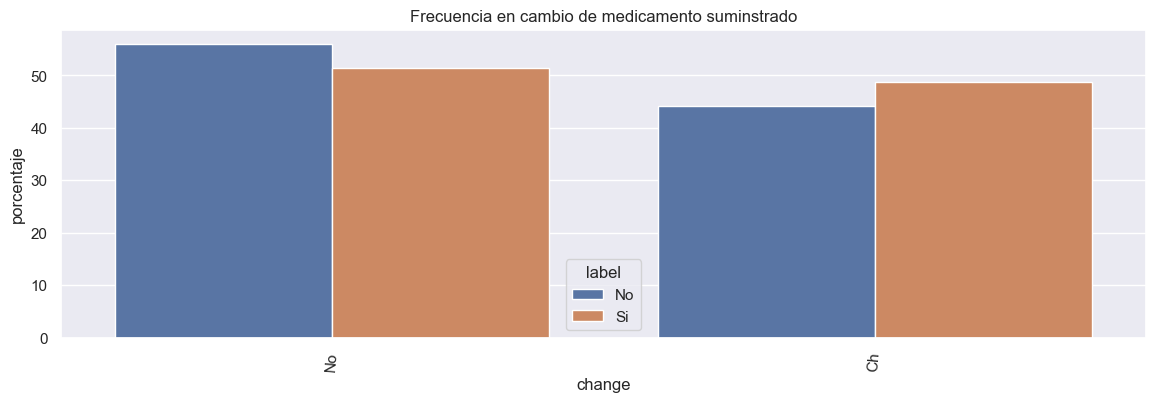

In [103]:
print(df.change.value_counts())
f, ax = plt.subplots(1,1, figsize=(14,4))
barplot_per_classes(df, 'change', 'label', 'Frecuencia en cambio de medicamento suminstrado', ticks_rotation=85)

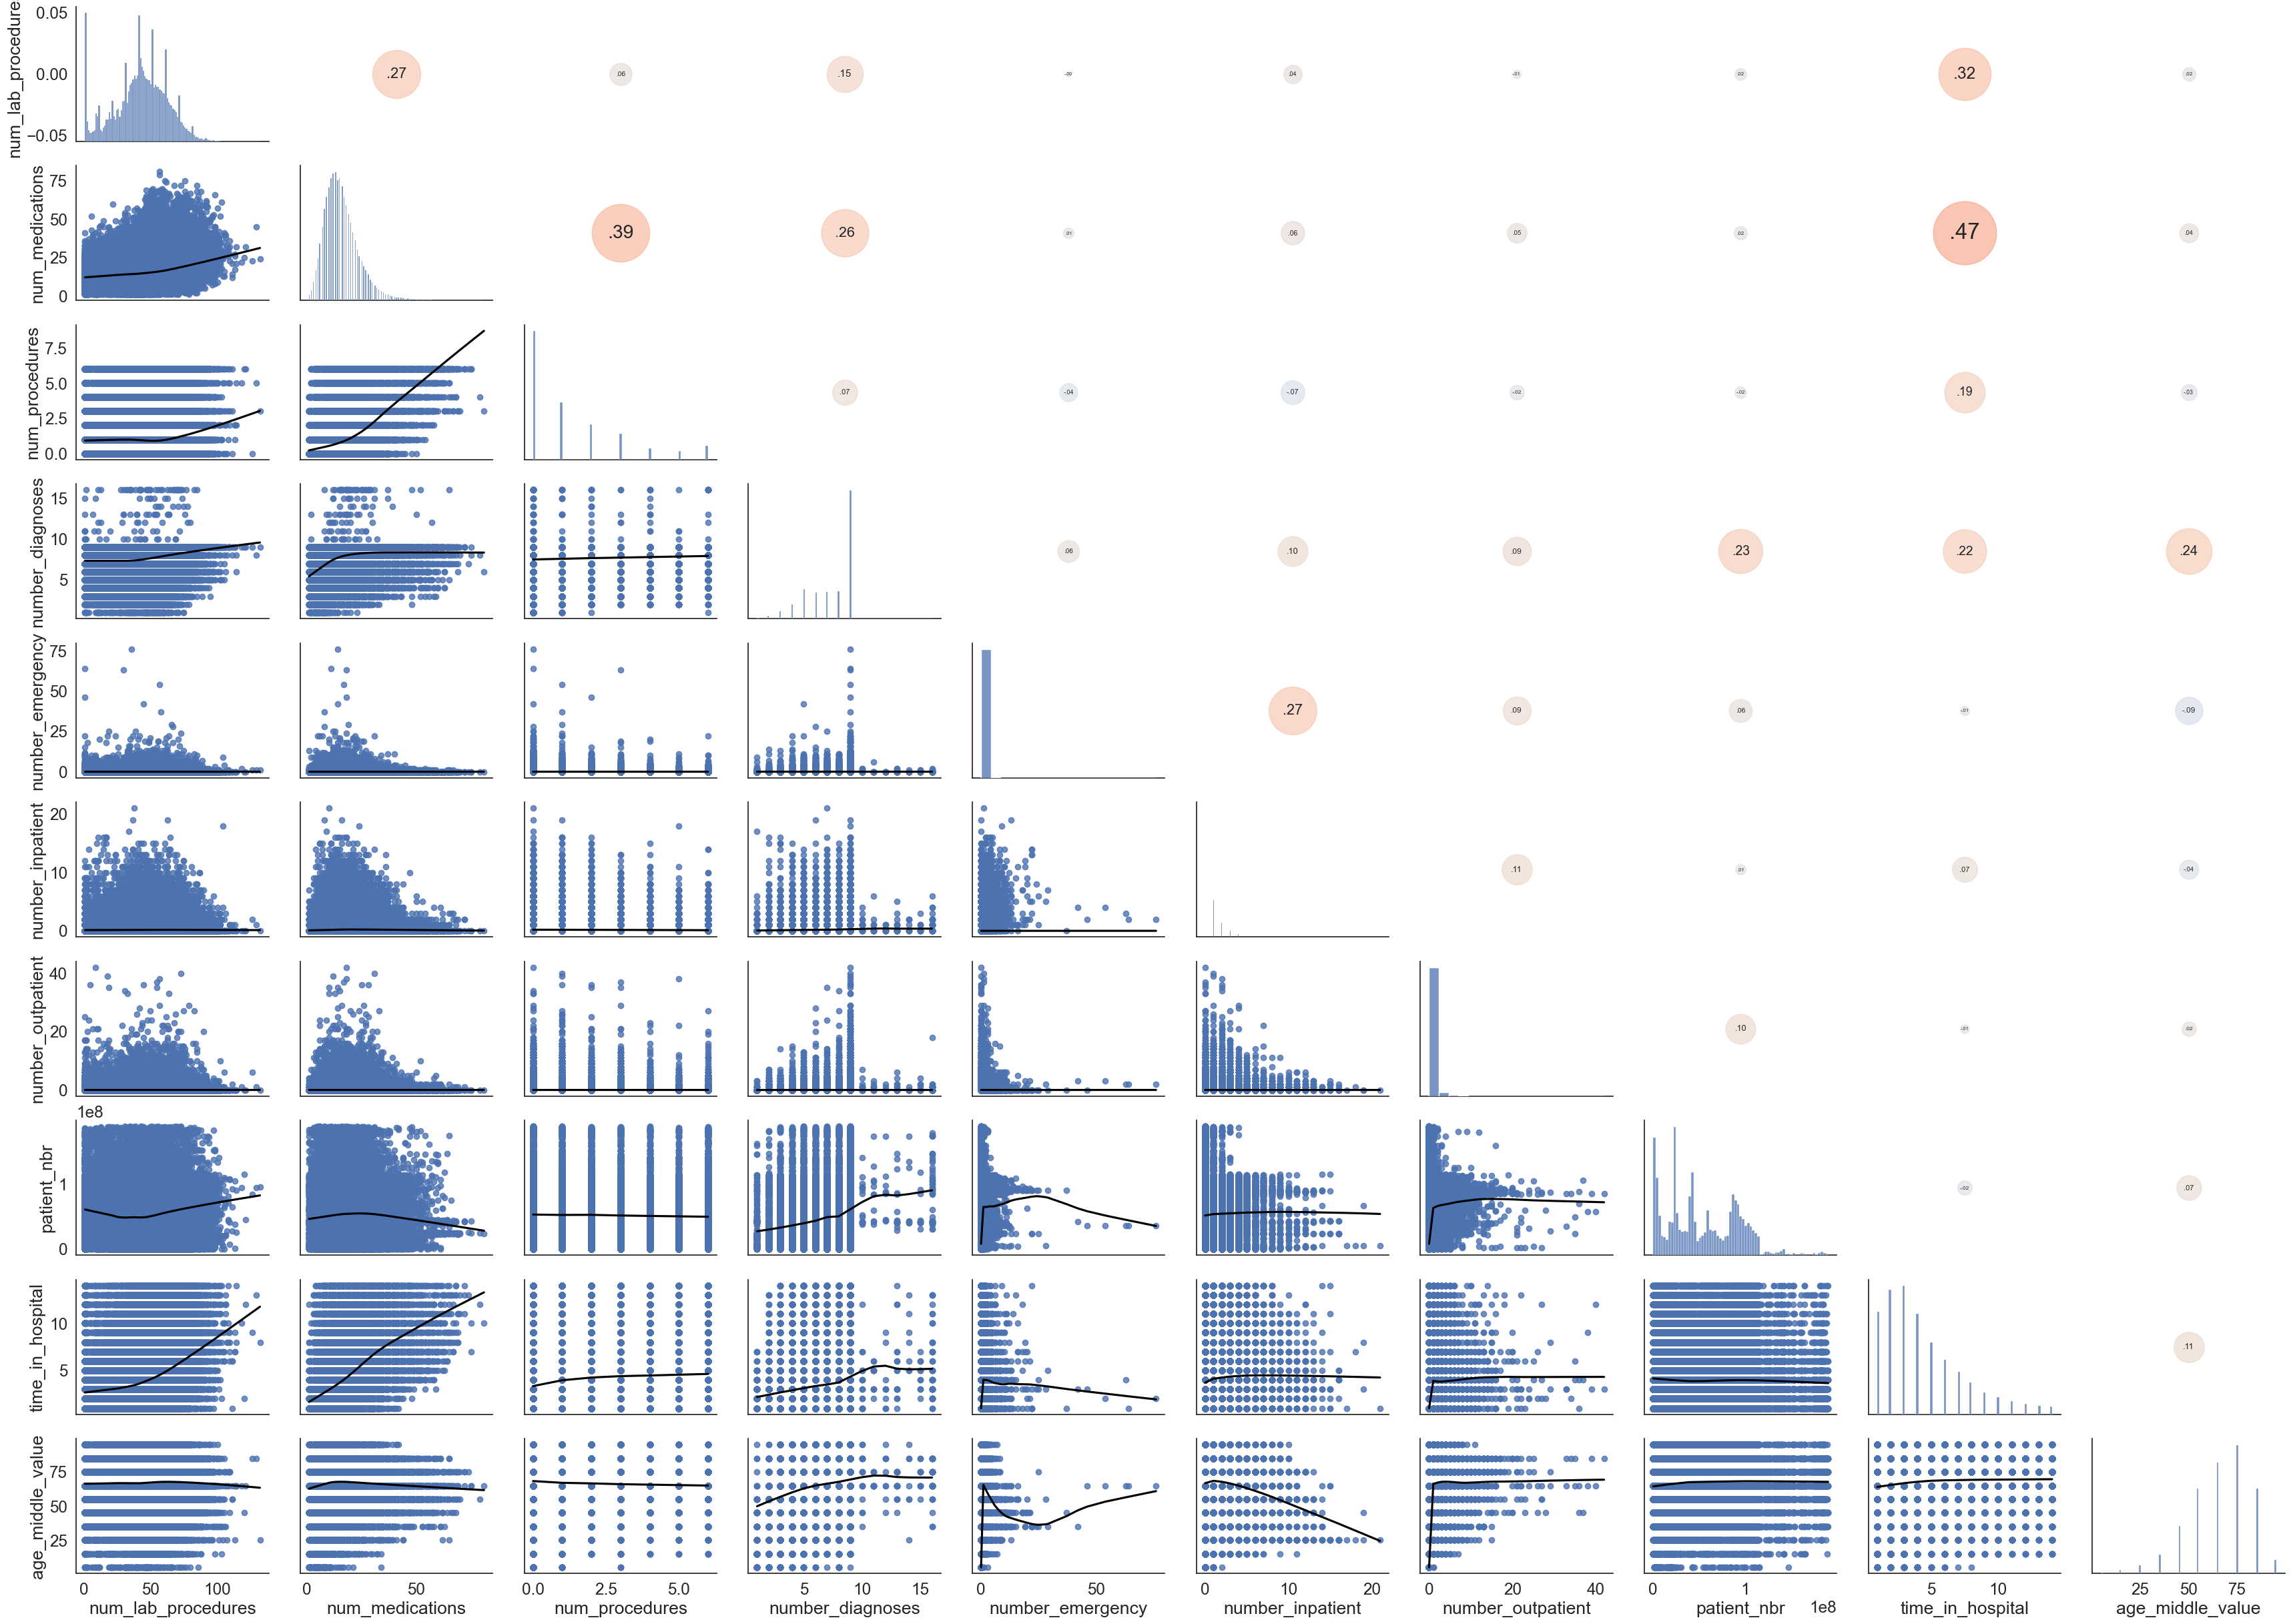

In [104]:
# grafico de  tendencias por cada par de  sensores  registrados, con su respectiva  linea  de  tenddencia y correlacion asignada
numeric_cols = df.select_dtypes(include=['int', 'float']).columns[1:]

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)

g = sns.PairGrid(df[numeric_cols], aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

#sns.pairplot(df[cols], markers='+')
plt.show()

En el grafico de correlacion anterior, se observa que no hay una presencia  muy  fuerte a tendencias lineales en la mayoria de los atributos numericos, 
implicando asi que no se induce a multicolinealidad ( dado a que las correlaciones estan por debajo del 47%)

In [105]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.7.0
numpy               1.24.2
pandas              1.5.3
plotly              5.13.0
prettytable         3.6.0
seaborn             0.12.2
session_info        1.0.0
src                 NA
-----
IPython             8.10.0
jupyter_client      7.4.9
jupyter_core        5.2.0
notebook            6.5.2
-----
Python 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22000-SP0
-----
Session information updated at 2023-02-25 12:04
